# The Laplace approximation applied to Bayesian Logistic Regression
## Andrei-Ioan Bleahu
##### 18th March 2025

Based on : https://mlpr.inf.ed.ac.uk/2024/notes/w9b_laplace_approximation.html

First let us create some fake data. For simplicity we have two classes, $0$ and $1$ and we want observations associated to them.

In [2]:
using Distributions
using Plots
using Random 
using LinearAlgebra
using StatsFuns

## Generate Data

In [3]:
nobs = 300
nfeats = 2 # we can plot them 2D
noise_scale = 0.2
ntrain = 20

20

Let's generate a matrix of random features first. We'll take $n$ observations and $p$ features. 

In [4]:
function generate_fakedata(nobs, nfeats, noise_scale)

    """
    Generates fake data for logistic regression: features
    and binary labels. 
    """
    
    Random.seed!(2345)
    X = randn(nobs, nfeats)
    w_true = rand(nfeats)
    println("True weights", w_true)

    lin_sig = X * w_true .+ randn(size(X, 1)) * noise_scale

    probabilities = logistic.(lin_sig)

    y = vec(Int.(probabilities .>= 0.5))

    return X, y

    end


generate_fakedata (generic function with 1 method)

In [5]:
X, y = generate_fakedata(nobs, nfeats, noise_scale)

True weights[0.5039217036663349, 0.5789357661433562]


([-1.1452757534674953 0.26585796928332517; -1.8954083760776357 1.7174245583374994; … ; -0.4641356221966029 0.41836676739105877; 0.12726564318845562 -0.23306614612859897], [0, 1, 1, 1, 0, 0, 0, 1, 1, 0  …  1, 0, 0, 1, 1, 1, 1, 1, 1, 0])

Let's understand if the data is linearly separable

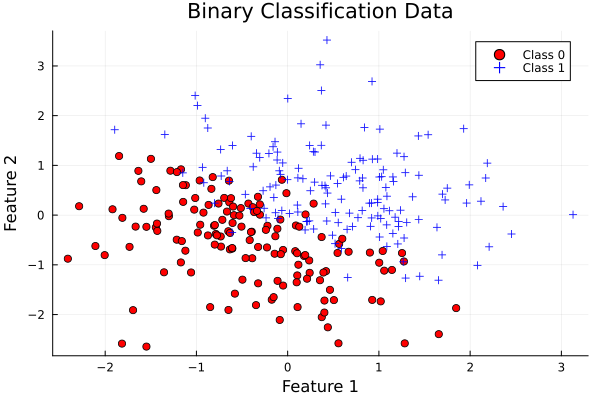

In [6]:
# Separate data points by class
X0 = X[y .== 0, :]
X1 = X[y .== 1, :]

# Scatter plot
scatter(X0[:, 1], X0[:, 2], color=:red, label="Class 0", marker=:circle)
scatter!(X1[:, 1], X1[:, 2], color=:blue, label="Class 1", marker=:cross)

# Labels
xlabel!("Feature 1")
ylabel!("Feature 2")
title!("Binary Classification Data")


OBserve:

- It seems the data is separable. 

In [7]:
function split_train_test(X, y, ntrain)
    """
    Splits synthethic data into training and test data.

    Args
    X : features
    y: labels
    ntrain : number of training samples
    """

    Random.seed!(2345)
    

    Xtrain = X[1:ntrain, :]
    ytrain = y[1: ntrain]

    Xtest = X[(ntrain+1): end, :]
    ytest = y[(ntrain+1): end]

    return Xtrain, ytrain, Xtest, ytest

end 

split_train_test (generic function with 1 method)

In [8]:
Xtrain, ytrain, Xtest, ytest = split_train_test(X, y, ntrain)

([-1.1452757534674953 0.26585796928332517; -1.8954083760776357 1.7174245583374994; … ; 0.5898022294789512 -0.6697974577857383; 0.986174471059214 0.2540755965898215], [0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1], [-0.6651432329610939 0.0714770670256725; -0.9228168919567369 0.05001124369548898; … ; -0.4641356221966029 0.41836676739105877; 0.12726564318845562 -0.23306614612859897], [0, 0, 0, 1, 1, 1, 0, 0, 1, 0  …  1, 0, 0, 1, 1, 1, 1, 1, 1, 0])

Let's see if the training data is linearly separable. 

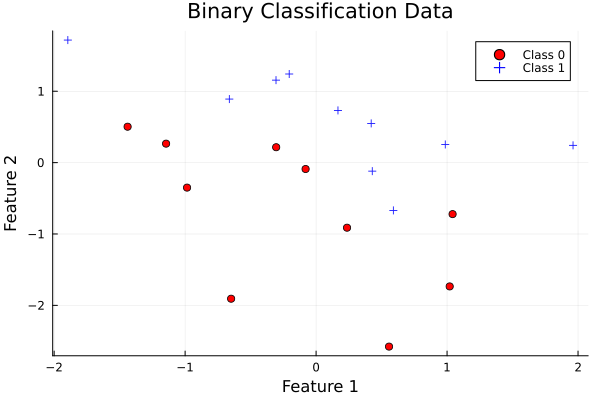

In [9]:
# Separate data points by class
X0 = Xtrain[ytrain .== 0, :]
X1 = Xtrain[ytrain .== 1, :]

# Scatter plot
scatter(X0[:, 1], X0[:, 2], color=:red, label="Class 0", marker=:circle)
scatter!(X1[:, 1], X1[:, 2], color=:blue, label="Class 1", marker=:cross)

# Labels
xlabel!("Feature 1")
ylabel!("Feature 2")
title!("Binary Classification Data")


In [10]:
Xtrain_bias = hcat(ones(ntrain), Xtrain)

20×3 Matrix{Float64}:
 1.0  -1.14528     0.265858
 1.0  -1.89541     1.71742
 1.0   0.420619    0.549376
 1.0  -0.66259     0.891038
 1.0  -0.985183   -0.350115
 1.0   0.236244   -0.911864
 1.0  -0.0801628  -0.0895053
 1.0  -0.20531     1.2416
 1.0  -0.30604     1.15626
 1.0   1.04217    -0.721507
 1.0   1.02005    -1.73466
 1.0   1.9618      0.242187
 1.0  -1.43913     0.503201
 1.0   0.556974   -2.57792
 1.0   0.167028    0.732182
 1.0   0.428822   -0.118791
 1.0  -0.304702    0.215823
 1.0  -0.648692   -1.9069
 1.0   0.589802   -0.669797
 1.0   0.986174    0.254076

In [11]:
ytrain 

20-element Vector{Int64}:
 0
 1
 1
 1
 0
 0
 0
 1
 1
 0
 0
 1
 0
 0
 1
 1
 0
 0
 1
 1

## Derivation: Bayesian Logistic Regression

### Posterior for Bayesian Logistic Regression

In logistic regression, we generate samples from a Bernoulli distribution. For one label:

$$
p(y^{(i)}|\mathbf{w}, \mathbf{x}^{(i)}) = \texttt{Bernoulli}(\sigma^{(i)}) =\begin{cases}\sigma(\mathbf{w}^\top\mathbf{x}^{(i)}) & y^{(i)} =1
\\
1-\sigma(\mathbf{w}^\top\mathbf{x}^{(i)}) & y^{(i)} = 0   \end{cases}
$$

In the above, $\sigma^{(i)}(\mathbf{w} \mathbf{x}^{(i)}) = \frac{1}{1+e^{-\mathbf{w}^\top\mathbf{x}}}$ is the logistic regression's output. We can write the Bernoulli distribution analytically

$$
p(y^{(i)}|\mathbf{w}, \mathbf{x}^{(i)}) = (\sigma^{(i)})^{y^{(i)}}(1-\sigma^{(i)})^{1-y^{(i)}}
$$

The above is just for one observation. We are interested in the expression for the joint-log likelihood.

 Now, since $y^{(i)}$ are conditionally independent given $\textbf{w}$, the joint likelihood is the product of the individual likelihoods for $\mathbf{x}^{(i)}$ :

$$
p(\{y^{(i)}\}|\mathbf{w}, \mathbf{X}) = \prod_{i=1}^{n} p(y^{(i)}|\mathbf{w}, \mathbf{x}^{(i)})
$$

where $\mathbf{X}$ is the feature matrix $\mathbf{X} = \begin{bmatrix}\mathbf{x}^{(1)}& \mathbf{x}^{(2)} & \ldots & \mathbf{x}^{(n)}\end{bmatrix}$. 

Taking the log transforms the product into a sum, so the joint log likelihood becomes:

$$
\ln p(\{y^{(i)}\}|\mathbf{w}, \mathbf{X}) = \sum_{i=1}^{n} \ln p(y^{(i)}|\mathbf{w}, \mathbf{x}^{(i)})
$$

Since the likelihood for probabilistic regression is given, we can write everything in terms of $\sigma^{(i)}(\mathbf{x}, \mathbf{w})$ :

$$
\ln p(\{y^{(i)}\}|\mathbf{w}, \mathbf{X}) = \sum_{i=1}^{n} \ln [(\sigma^{(i)})^{y^{(i)}}(1-\sigma^{(i)})^{1-y^{(i)}}]
$$


In the above, I simply substituted the right hand side term of the likelihood for the probabilisitic logistic regression, under the logaritm. Now, we can apply the logarithm to obtain the summand for the joint log-likelihood.

$$
\ln p(\{y^{(i)}\}|\mathbf{w}, \mathbf{X}) = \sum_{i=1}^{n} ( y^{(i)} \ln \sigma^{(i)} + (1 - y^{(i)}) \ln (1 - \sigma^{(i)}) )
$$





A Bayesian logistic regression model usually assumes a zero mean Gaussian prior for the weight parameter $\mathbf{w}$:

$$p(\mathbf{w}|\lambda) = \mathcal{N}_m\left(\mathbf{w}; \mathbf{0}, \frac{1}{\lambda}\mathbf{I}\right)=\prod_{d=1}^m \mathcal{N}(w_d; 0, 1/\lambda)$$

* where $ \mathcal{N}_m $ denotes a $m-dimensional$ Gaussian distribution and where 

* $\lambda$ is the precision parameter of the Gaussian.

Taking the logarithm of the prior means that (i) the product becomes a sum of (ii) the logarithm of the terms under the product. This means that :

$$ \ln p(\mathbf{w}|\lambda) =\sum_{d=1}^m \ln \mathcal{N}(w_d; 0, 1/\lambda)$$

Each term under the logarithm is a zero-centered gaussian distribution with precision parameter $\lambda = \frac{1}{\sigma ^{2}}$ where $\sigma^{2}$ is the variance of the distribution. Keeping this in mind, the probability density function of each gaussian distribution can be written as:

$$ \mathcal{N}(w_d; 0, 1/\lambda) = f(w_d) = (\frac{\lambda}{2 \pi})^{\frac{1}{2}} \exp (- \frac{\lambda}{2} w_d^{2}) $$

<p>

Taking the logarithm of this expression simplifies matters as it extract the term under the exponential:

$$ \ln \mathcal{N}(w_d; 0, 1/\lambda) = \frac{1}{2} \ln (\frac{\lambda}{2 \pi}) - \frac{\lambda}{2} w_d^{2} $$

Now, taking the sum from $1$ to $m$ yields:

$$ \ln p(\mathbf{w}|\lambda) = \frac{m}{2} \ln (\frac{\lambda}{2 \pi}) - \frac{\lambda}{2} \sum_{d=1}^m w_d^{2} $$

However, the sum is simply the product of the $\mathbf{w}$ with its transpose. And hence

$$ \ln p(\mathbf{w}|\lambda) = \frac{m}{2} \ln (\frac{\lambda}{2 \pi}) - \frac{\lambda}{2} \mathbf{w}^T  \mathbf{w} $$

In the above, $m$ is the length of the vector $\mathbf{w} $ .

According to Bayes' rule, our posterior is :

$$
p(\mathbf{w}|\{y^{(i)}\}, \mathbf{X}) = \frac{p(\{y^{(i)}\}|\mathbf{X}, \mathbf{w}) p(\mathbf{w}|\lambda) }{ p(\{y^{(i)}\}, \mathbf{X})}
$$


Now if we apply the logarithm we obtain

$$
\ln p(\mathbf{w}|\{y^{(i)}\}, \mathbf{X}) = \ln p(\mathbf{w}|\lambda) + \ln p(\{y^{(i)}\}|\mathbf{X}, \mathbf{w}) +\text{const}
$$

Considering our calculation for the log-prior and log-likelihood we have: 

$$
\ln p(\mathbf{w}|\{y^{(i)}\}, \mathbf{X}) =  \frac{m}{2} \ln (\frac{\lambda}{2 \pi}) - \frac{\lambda}{2} \mathbf{w}^T  \mathbf{w} + \sum_{i=1}^{m} y^{(i)} \ln \sigma^{(i)} + (1 - y^{(i)}) \ln (1 - \sigma^{(i)}) +\text{const}
$$

### Laplace Approximation

As we see above, we can only evaluate the posterior distribution up to a constant. This constant is the normalizing constant $p(\{y^{(i)}\}, \mathbf{X}) = p(D)$

For simplicity let us denote the data 

$$
D = (\{ y^{(i)} \}, \mathbf{X} ) 
$$

It is simply the labels and the feature matrix of observations. 

We can actually express the posterior as the following:

$$
p(\mathbf{w} \vert D) = \frac{p(\mathbf{w} , D)}{p(D)}
$$

Since $p(D)$ is just a constant, we have:

$$ 
\mathbf{w}^* = \arg\max_{w} p(\mathbf{w} \vert D) = arg\max_{w} p(\mathbf{w} , D) 
$$

So we can apply Taylor's expansio at the maximum  $E(w$

Let us introduce an energy term that we wish to minimize. Since maximising a function is the same as minimizing its negative 

$$ 
E(\mathbf{w}) = - \ln{p(\mathbf{w}, D)}
$$

The LaPlace approximation is mathcing the minimum (Gradient is 0) and curvature(Hessian -second derivative) of the negative log joint probability to those of a Gaussian energy:

$$
p(\mathbf{w} \vert D) \approx N(\bf w; w^*, H^{-1})
$$

Let's put this into analutical form. We simply have to replace the mean and variance in the Gaussian :

$$
p(\mathbf{w} \vert D ) = (\frac{1}{2 \pi})^{\frac{d}{2}}  (\vert \mathbf{H} \vert^{\frac{1}{2}}) \exp{ \{ - \frac{1}{2} \bf (w - w^*)^T H (w - w^*) \}}
$$

Clearly :

$$
p(\mathbf{w}^* \vert D ) = (\frac{1}{2 \pi})^{\frac{d}{2}}  (\vert \mathbf{H} \vert^{\frac{1}{2}}) 
$$

Also considering that :

$$
p(\mathbf{w}^* \vert D) = \frac{p(\mathbf{w}^* , D)}{p(D)}
$$

We can recover the evidence term :

$$
p(D) = p(\mathbf{w}^* , D) (2 \pi)^{\frac{d}{2}} \frac{1}{(\vert \mathbf{H} \vert^{\frac{1}{2}}) }
$$

## Implementation.

### Find the MAP estimate $\mathbf{w}^*$

The first step seems to be finding the minimum of the energy $\bf w^*$  Let's recall that the energy is basically:


$$ 
E(\mathbf{w}) = - \ln{p(\mathbf{w}, D)}
$$

Which is the same as :


$$ 
E(\mathbf{w}) = - \ln{p(\mathbf{w} \vert D)} - \ln{p(D)}
$$ 

Previously we have shown that the posterior is :

$$
\ln p(\mathbf{w}|\{y^{(i)}\}, \mathbf{X}) =  \frac{m}{2} \ln (\frac{\lambda}{2 \pi}) - \frac{\lambda}{2} \mathbf{w}^T  \mathbf{w} + \sum_{i=1}^{m} \{y^{(i)} \ln \sigma^{(i)} + (1 - y^{(i)}) \ln (1 - \sigma^{(i)})\} - \ln{p(\{y^{(i)}\}, \mathbf{X})}
$$

This is essentially:

$$
\ln p(\mathbf{w}| D) =  \frac{m}{2} \ln (\frac{\lambda}{2 \pi}) - \frac{\lambda}{2} \mathbf{w}^T  \mathbf{w} + \sum_{i=1}^{m} \{y^{(i)} \ln \sigma^{(i)} + (1 - y^{(i)}) \ln (1 - \sigma^{(i)})\} - \ln{p(D)}
$$

So the energy is :

$$
E(\mathbf{w}) = - \frac{m}{2} \ln (\frac{\lambda}{2 \pi}) + \frac{\lambda}{2} \mathbf{w}^T  \mathbf{w} - \sum_{i=1}^{m} \{y^{(i)} \ln \sigma^{(i)} + (1 - y^{(i)}) \ln (1 - \sigma^{(i)})\}
$$ 


The first term on the right hand side does not depend on $\mathbf{w}$, so we are only interested in optimizing:

$$
E(\mathbf{w}) =  \frac{\lambda}{2} \mathbf{w}^T  \mathbf{w} - \sum_{i=1}^{m} y^{(i)} \ln \sigma^{(i)} + (1 - y^{(i)}) \ln (1 - \sigma^{(i)}) 
$$ 

For simplicity, we can put this into vector form. First let us recall:

$$
\bf y = X w
$$

Which is the same as saying that each  $y^{(i)}$ is :

$$
y^{(i)} = \mathbf{w}^T \mathbf{x}^{(i)}
$$



So we can define a vector such that :

$$
\mathbf{\sigma} = \sigma{(\bf X w)}
$$

In vector form this becomes:



$$
E(\mathbf{w}) =  \frac{\lambda}{2} \mathbf{w}^T  \mathbf{w} - [\bf y^T \ln \sigma + (1 - y)^T \ln (1 - \sigma) ] \tag{1}
$$ 

It is interesting to note that the sum in the brackets is simply the cross entropy and we can calculate the gradient of it.

**Derivation of the gradient of the cross entropy function** :

The sum is basically the Cross-Entropy loss :

$$
L(\mathbf{w}) = \sum_{i=1}^{m} y^{(i)} \ln \sigma^{(i)} + (1 - y^{(i)}) \ln (1 - \sigma^{(i)}) 
$$

The difference is that we are missing a normalising factor $\frac{1}{n}$.

Step 1 

For simplicity, I will first calculate the gradients of the logistic function  $ \ln \sigma^{(i)} $ :



$$ \nabla_{\mathbf{w}} \ln \sigma^{(i)} = \frac {1}{\sigma^{(i)}} \sigma^{(i)} ( 1 - \sigma^{(i)}) \mathbf{x}^{(i)}$$ 

where I first applied the gradient to the logarithm itself, then to the kernel (the sigma function) and then to the argument of the kernel. It is clear that the denominator cancels out with the first sigmoid function This results in : 

$$

\nabla_{\mathbf{w}} \ln \sigma^{(i)} = (1 - \sigma^{(i)}) \mathbf{x}^{(i)} 

$$

</ul>

Step 2

By applying the same logic, I will calculate the gradient of $ 1- \ln \sigma{(i)} $ :

$$ 
\nabla_{\mathbf{w}} \ln(1 - \sigma^{(i)}) = - \sigma^{(i)} \mathbf{(x)}^{(i)} 

$$

Step 3 

<ul>

1. Apply gradient to the loss function, which means applying the gradient to the sigmoid expressions multiplied by their corresponding ${y}$ factors (which act like constants)
2. Multiply the result of Eq. 1 with $ {y}^{(i)}$ and the results of Eq.2 with  $1 - {y}^{(i)}$ 
3. Order the terms and obtain (Eq. 3)  as follows: 

$$
\nabla_{\mathbf{w}} (L(\mathbf{w}))=  \sum_{i=1}^n \{ ( {y}^{(i)} - \sigma^{(i)} ) \mathbf{x}^{i} \}
$$



</ul>


$$
\nabla_{\mathbf{w}} (L(\mathbf{w}))=  - {X}^{T} ( \mathbf{\sigma} - \mathbf{y}) 
$$ 

Using this result, we can now write the gradient for the energy:


$$
\nabla_{\mathbf{w}} (E(\mathbf{w}))=  \lambda \mathbf{w} + {X}^{T} ( \mathbf{\sigma} - \mathbf{y}) \tag{2}
$$ 


Now, this equation is definitely not linear so finding the MAP estimate directly by equating the gradient with 0 and solving it seems difficult. So, we can implement gradient descent. For this we need functions for the energy, the gradient and the gradient descent algorithm.

Let's set $\lambda = \lambda_c$ our hyperparamters

In [12]:
λ_c = 1.6

1.6

In [13]:
function energy(X, y, w; λ = λ_c)
    """
    Calculates energy function.
    """
    
    n = length(y)

    epsilon = 1e-9
    
    reg = 0.5 * λ * w' * w
    
    σ = logistic.(X * w)
    
    # to transforms 1-element vector into scalar
    return reg .- (y' * log.(σ .+ epsilon) .+ (ones(n) .- y)' * log.(ones(n) .- σ .+ epsilon))[1] 

end


energy (generic function with 1 method)

In [14]:
function energy_gradient(X, y, w; λ = λ_c)
    """
    Implement the energy gradient
    """

    reg = λ * w 

    σ = logistic.(X * w)

    return reg .+ X' * (σ .- y)

end

energy_gradient (generic function with 1 method)

In [15]:
function grad_desc(X, y, γ; max_iters = 1000, λ = λ_c)
    """
    Implements Gradient Descent to find the minimum of
    the energy.
    """

    N, D = size(X)

    w = zeros(D)

    E =  energy(X, y, w)

    Es = [E]

    for k in 1:max_iters

        gradient = energy_gradient(X, y, w)

        w[2:end] = w[2:end] .- γ * gradient[2:end]

        E = energy(X, y, w)

        push!(Es, E) 

    end

    return w, Es

end

grad_desc (generic function with 1 method)

In [16]:
w_map, energies = grad_desc(Xtrain_bias, ytrain, 0.001)

([0.0, 0.6771212705001156, 1.258197172879701], [13.862943571198906, 13.816238909161317, 13.770134601964473, 13.724622144485696, 13.679693131649426, 13.635339258739364, 13.591552321628889, 13.548324216932759, 13.505646942083185, 13.46351259533328  …  9.432955941176035, 9.432929879416687, 9.432903982038123, 9.432878247994452, 9.432852676246524, 9.432827265761883, 9.432802015514731, 9.432776924485875, 9.432751991662695, 9.432727216039085])

In [17]:
w_map

3-element Vector{Float64}:
 0.0
 0.6771212705001156
 1.258197172879701

In [18]:
energies

1001-element Vector{Float64}:
 13.862943571198906
 13.816238909161317
 13.770134601964473
 13.724622144485696
 13.679693131649426
 13.635339258739364
 13.591552321628889
 13.548324216932759
 13.505646942083185
 13.46351259533328
 13.421913375690927
 13.380841582786068
 13.340289616674324
  ⋮
  9.43300856205462
  9.432982168368842
  9.432955941176035
  9.432929879416687
  9.432903982038123
  9.432878247994452
  9.432852676246524
  9.432827265761883
  9.432802015514731
  9.432776924485875
  9.432751991662695
  9.432727216039085

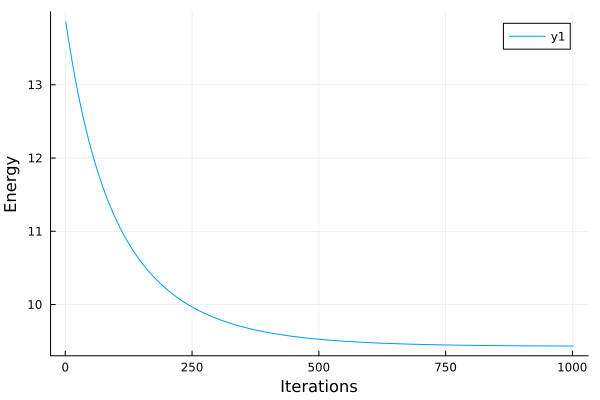

In [19]:
plot(energies, xlabel = "Iterations", ylabel = "Energy")

### Compute the Hessian

The Hessian is the second derivative, so we must take the gradient with respect to $\mathbf{w}$ of $ \nabla_{\mathbf{w}} (E(\mathbf{w}))$:

So our Hessian becomes:

$$
H = \lambda \mathbf{I} + \mathbf{X}^T \bf \sigma (1 - \sigma) X
$$

The first term was straightfoward to diferentiate, as for the second term we only needed the differential with respect to $\mathbf{w}$

In [20]:
function hessian(X, y, w; λ = λ_c)

    """
    Calculates the hessian
    """

    σ = logistic.(X * w)

    # diagonal matrix
    W = Diagonal( σ .* (1 .- σ))

    return λ * I + X' * W * X

end 


hessian (generic function with 1 method)

Let's drop the bias from our calculated $w_{MAP}$

In [21]:
w_map = w_map[2:end]

2-element Vector{Float64}:
 0.6771212705001156
 1.258197172879701

We need the Hessian at $w_{map}$

In [22]:
H = hessian(Xtrain, ytrain, w_map; λ = λ_c)

2×2 Matrix{Float64}:
  4.84889  -1.53239
 -1.53239   4.54492

In [23]:
H_ = inv(H)

2×2 Matrix{Float64}:
 0.230829   0.0778276
 0.0778276  0.246267

### Computing logistic regression predictions

So let's recall the approximation:

$$
p(\mathbf{w} \vert D) \approx N(\bf w; w^*, H^{-1})
$$

We can write this in analytical form:

$$ 
p(\mathbf{w} \vert D) \approx \frac{\vert \bf H \vert^{\frac{1}{2}}}{ (2 \pi)^{D/2} } \exp{ \{ -\frac{1}{2} \bf (w - w^*)^T H  (w - w^*)\}}
$$

Now, we want to predict $\bf y^*$ test samples on $ \bf X^*$ test observations. We  can marginalize based on the posterior. 

$$ 
p(\mathbf{y}^* \vert \mathbf{X}^*, D) = \int p(\mathbf{y}^*, \mathbf{w} \vert \mathbf{X}^*, D)  d\mathbf{w}
$$

$$ 
p(\mathbf{y}^* \vert \mathbf{X}^*, D) = \int p(\mathbf{y}^* \vert \mathbf{X}^*, \mathbf{w}) p(\mathbf{w} \vert D) d\mathbf{w}
$$

Now, we know that our predictions are:

$$
y^* = \sigma{ (\bf X w)}
$$

So :

$$ 
p(\mathbf{y}^* \vert \mathbf{X}^*, D) = \int \sigma{ (\bf X w)} p(\mathbf{w} \vert D) d\mathbf{w}
$$

This is the same as saying :

$$ 
p(\mathbf{y}^* \vert \mathbf{X}^*, D) = \int \sigma{ (\bf X w)} N(\bf w; w^*, H^{-1}) d\mathbf{w}
$$

This is practically the expectation over the posterior, so we can approximate it:

$$

p(\mathbf{y}^* \vert \mathbf{X}^*, D) = E_{N(\bf w; w^*, H^{-1})} [\sigma{ (\bf X w)}] 
$$

This means that for a single predictions we have :

$$

p(\mathbf{y}^* \vert \mathbf{x}^{i*}, D) = E_{N(\bf w; w^*, H^{-1})} [\sigma{ (\bf w^T x^{(i*)})}] 
$$

It seems this integral is not computable, but we can use Monte Carlo methods to sample from the approximated posterior and calculate the mean over many samples (the expected value over that distribution)

#### Simple MC 

1. Sample from  $N(\bf w; w^*, H^{-1})$

2. Make predictions 

3. Burn out the first 1000 predictions and keep the rest

4. Calculate the expected value(mean)


In [24]:
function simple_MC(X, w_map, H_; burnin = 1000, num_samples = 5000)

    predictions_matrix = zeros(num_samples, size(X, 1))

    for i in 1:(burnin + num_samples)

        w_sample = w_map + rand(MvNormal(zeros(length(w_map)), Matrix(Symmetric(H_))))

        if i > burnin

            # vector of proabilities
            σ_sample = logistic.(X * w_sample)

            predictions_matrix[i - burnin, :] = σ_sample
        end 

    end 

    

    return mean(predictions_matrix, dims = 1)

end 


simple_MC (generic function with 1 method)

Make predictions at particular x and do for loop

In [25]:
yprobs_mc = simple_MC(Xtest, w_map, H_)

1×280 Matrix{Float64}:
 0.413052  0.36902  0.280795  0.460565  …  0.694834  0.552062  0.4486

The predictions are then simply :


In [26]:
ypred_mc = vec(Int.(yprobs_mc .>= 0.5))

280-element Vector{Int64}:
 0
 0
 0
 0
 1
 1
 0
 0
 1
 1
 0
 0
 0
 ⋮
 1
 1
 0
 0
 0
 1
 1
 1
 1
 1
 1
 0

In [27]:
ytest

280-element Vector{Int64}:
 0
 0
 0
 1
 1
 1
 0
 0
 1
 0
 0
 0
 0
 ⋮
 1
 1
 1
 0
 0
 1
 1
 1
 1
 1
 1
 0

So let us calculate the accuracy of our predictions. 

In [28]:
mean(ytest .= ypred_mc)

0.5071428571428571

In [29]:
min_values = minimum(Xtrain, dims=1)


1×2 Matrix{Float64}:
 -1.89541  -2.57792

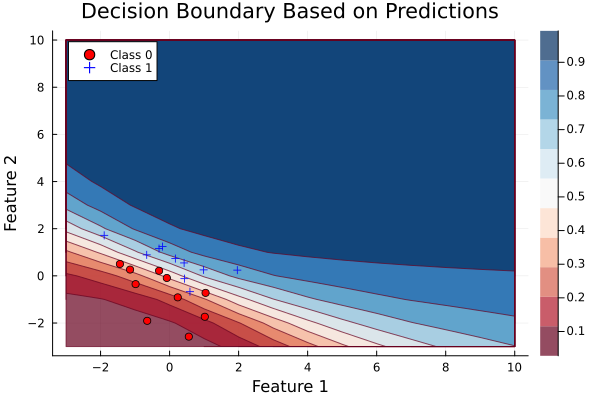

In [30]:
# Generate grid data
xx1 = collect(-3:1:10)  # 1D vector from minimum
xx2 = collect(-3:1:10)  # 1D vector

xx1_mesh = repeat(xx1', length(xx2), 1)  # Repeats across rows
xx2_mesh = repeat(xx2, 1, length(xx1))  # Repeats across columns

# Flatten vectors
grid_xx1 = vec(xx1_mesh)  
grid_xx2 = vec(xx2_mesh)  

X_test = hcat(grid_xx1, grid_xx2)

yprobs_mc = simple_MC(X_test, w_map, H_)

# Transpose yprobs_mc to make it a column vector
yprobs_mc = yprobs_mc'

# Reshape to match the grid
Z = reshape(yprobs_mc, (length(xx2), length(xx1)))

# Plot the decision boundary
contourf(xx1, xx2, Z, fill=true, levels=10, color=:RdBu, alpha=0.7, colorbar=true)

# Scatter training data
X0 = Xtrain[ytrain .== 0, :]
X1 = Xtrain[ytrain .== 1, :]

scatter!(X0[:, 1], X0[:, 2], color=:red, label="Class 0", marker=:circle)
scatter!(X1[:, 1], X1[:, 2], color=:blue, label="Class 1", marker=:cross)

xlabel!("Feature 1")
ylabel!("Feature 2")
title!("Decision Boundary Based on Predictions")
plot!()